In [ ]:
import os
# Add figures to notebook, if they don't appear (reload this page after calling this cell)
os.symlink('/home/shared/cogneuro-connector/data/Week07_IntroFMRI_RawData/figures/','figures')

# Overview 

In this half of the lecture we will introduce software to display fMRI data on a 3D representation of the cortical surface.

# Goals
* Understand the way pycortex represents a volumetric data set
* Create pycortex Volume objects from 3D data, masked data, and time series data
* Display data on the cortical surface

## Alignment
fMRI measures activity across the whole brain (or large swathes of the brain), but it is difficult to map that activity to specific anatomical locations in the brain based on functional data alone. Many factors make anatomy ambiguous in functional data: **(1)** functional data are low resolution; **(2)** functional slices are not always aligned with the head in a consistent or precise way across subjects; and **(3)** there is considerable variation in anatomy (i.e., specific locations of sulci & gyri) across subjects. Thus, a common step in fMRI processing is to align the functional data with a high-resolution anatomical scan of the same subject. 

### Alignment in principle
The scanner stores the location of the slices with respect to the magnet *isocenter* (the strongest point of the magnetic field in the MRI scanner; the center of the magnet). This data is transferred to the nifti files at file creation time. These transformations (from data space to scanner space) are still not enough to precisely align data from different anatomical and functional scans. The functional and anatomical data may have been collected on different days, or the subject may have shifted slightly between scans. Thus, the functional data needs to be moved and/or rotated in 3D to make sure it aligns as precisely as possible with the underlying anatomical data. 
<img src="figures/fMRI_Transforms.001.png" align='left' style="height: 400px;">


### Alignment in pycortex
pycortex allows manual adjustment of the rotation & position of the functional data with respect to the 3D surface.
<img src="figures/pycortex_aligner_transverse.png" align='left' style="height: 200px;">


## Cortical surface extraction

fMRI studies often focus on the cerebral cortex (the outermost layer of the brain). Consequently, it is common to display the results of statistical analyses of fMRI data on inflated and flattened representations of the cerebral cortex. Such cortical surface maps provide a way to examine all cortical fMRI data at once, with the anatomical location of the functional data made clear. 

The cortical surface must be computationally extracted from high spatial resolution anatomical MRI scans, and often manually edited (*NOTE: Manual editing to create a good corical surface can take days or weeks of effort! This data is not free!*)

<img src="figures/MPRAGE.png" align='left' style="height: 200px;">

<img src="figures/MPRAGE_wcortex.png" align='left' style="height: 200px;">

<img src="figures/cortex_3views.png" align='left' style="height: 200px;">




In [1]:
# Load some necessary libraries
import os
import nibabel  # Neuroimaging library to work with MR images
import cortex  # This is our mapping software pycortex
import neurods # Our class module
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Set matplotlib defaults
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load data

Same as previously: load using nibabel, use get_data() method of the nibabel data object, transpose resulting data array, and zscore the data. For now, we will treat this as a generic data set (next week, we will learn more about the experiment that generated this data as we begin to actually analyze the data).

In [2]:
neurods.io.data_list

{'ecog': '/home/shared/cogneuro-connector/data/ecog/',
 'eeg': '/home/shared/cogneuro-connector/data/eeg/',
 'fmri': '/home/shared/cogneuro-connector/data/fmri/'}

In [3]:
basedir = os.path.join(neurods.io.data_list['fmri'], 'categories')
fname = os.path.join(basedir, 'sub01_categories1_1.nii.gz')
nii = nibabel.load(fname) 
voldata = nii.get_data().T
mask_fname = os.path.join(basedir, 's01_category_mask_cortical.npz')
mask = np.load(mask_fname)['mask']
data = voldata[:, mask]
data = zscore(data, axis=0)

In [4]:
first_volume = voldata[0]
print("Dimensions of the first volume: {0}".format(first_volume.shape))
print("Dimensions of the data: {0}".format(data.shape))

Dimensions of the first volume: (30, 100, 100)
Dimensions of the data: (120, 38543)


That is: (time, Z, Y, X). 

# Onward to 3D data visualizations! 

We will use a python module called pycortex to show data in 3D on the brain. This module was developed here at UC Berkeley in the Gallant lab, mostly by James Gao, with help from Alex Huth, Mark Lescroart, and other lab members. The code is freely available online [here](https://github.com/gallantlab/pycortex), and a paper summarizing the code can be found [here](http://journal.frontiersin.org/article/10.3389/fninf.2015.00023/full). 

To map the functional data onto the cortex, pycortex requires at least two things:

1. The cortical surface of the subject. 
    * pycortex stores cortical surface files (and several other files) for each subject in a reliably structured directory of files. Because of this reliable directory structure, all we need to provide to the code is a subject ID string, and the code will be able to find and load the relevant cortical surface files. 
2. The functional to anatomical aligmnent of this data to that cortical surface
    * Alignment of functional data to anatomical data proceeds by an *affine transform*. How this transformation works is beyond the scope of this class, but you can look it up on [wikipedia](https://en.wikipedia.org/wiki/Affine_transformation) or in your favorite linear algebra textbook if you're curious. **[would be good to have some better references here]**. The practical upshot is that a 4x4 matrix of numbers is sufficient to store the 3 rotations (around the x, y, and z axes) and 3 the transformations (in the x, y and z dimensions) that will transform the functional data in space such that they are aligned with the anatomical data (with the cortical surface). In the pycortex code, "transform" is abbreviated in variable names as `xfm`. Just as with the cortical surface, we only need to specify a name for a transform, and the code will know where to find the file that contains the affine transformation matrix. 

In [5]:
# (1) subject (specifies the cortical surface of the brain)
subject = 'S2' 
# (2) transform = functional-to-anatomical alignment
transform = 'S2_category_auto' 

To display data in pycortex, we need to create a pycortex object that contains all the relevant information: the data, the cortical surface (i.e., the subject) and the affine transform. That object is called a Volume.

In [10]:
# Create a volume
data_volume = cortex.Volume(first_volume, subject, transform) 
print(data_volume)

<Volumetric data for (S2, S2_category_auto)>


In [11]:
# Show the volume in a 3D brain (ooooh)
cortex.webgl.show(data_volume)

Testing new webshow...
https://data8.berkeley.edu/user/mark.lescroart/proxy/16816/mixer.html
Started server on port 16816


<WebApp(Thread-4, started 140307074262784)>

['rois']


## Breakout session
> Explore the viewer! Play with buttons: flatten, color map, color limits, depth. 

Color maps are important! See [this blog post](http://bids.github.io/colormap/) by our local BIDS fellows on why you should be careful about selecting a color map.

In [13]:
### TEACHER INFO
# show how to create a viewer with a different color map
data_volume = cortex.Volume(first_volume, subject, transform, cmap='viridis', vmin=0, vmax=1500)
cortex.webgl.show(data_volume)
# Relate this back to MNE: this is like a `raw` object in MNE. It's a wrapper around a channels x time array, 
# which allows you to show the data via other functions. This is a common thing to do in compuational work: 
# to create objects that contain some meta-information, and allow you to do interesting things you couldn't 
# do with plain arrays. 

Testing new webshow...
https://data8.berkeley.edu/user/mark.lescroart/proxy/51477/mixer.html
Started server on port 51477


<WebApp(Thread-5, started 140307065870080)>

['rois']


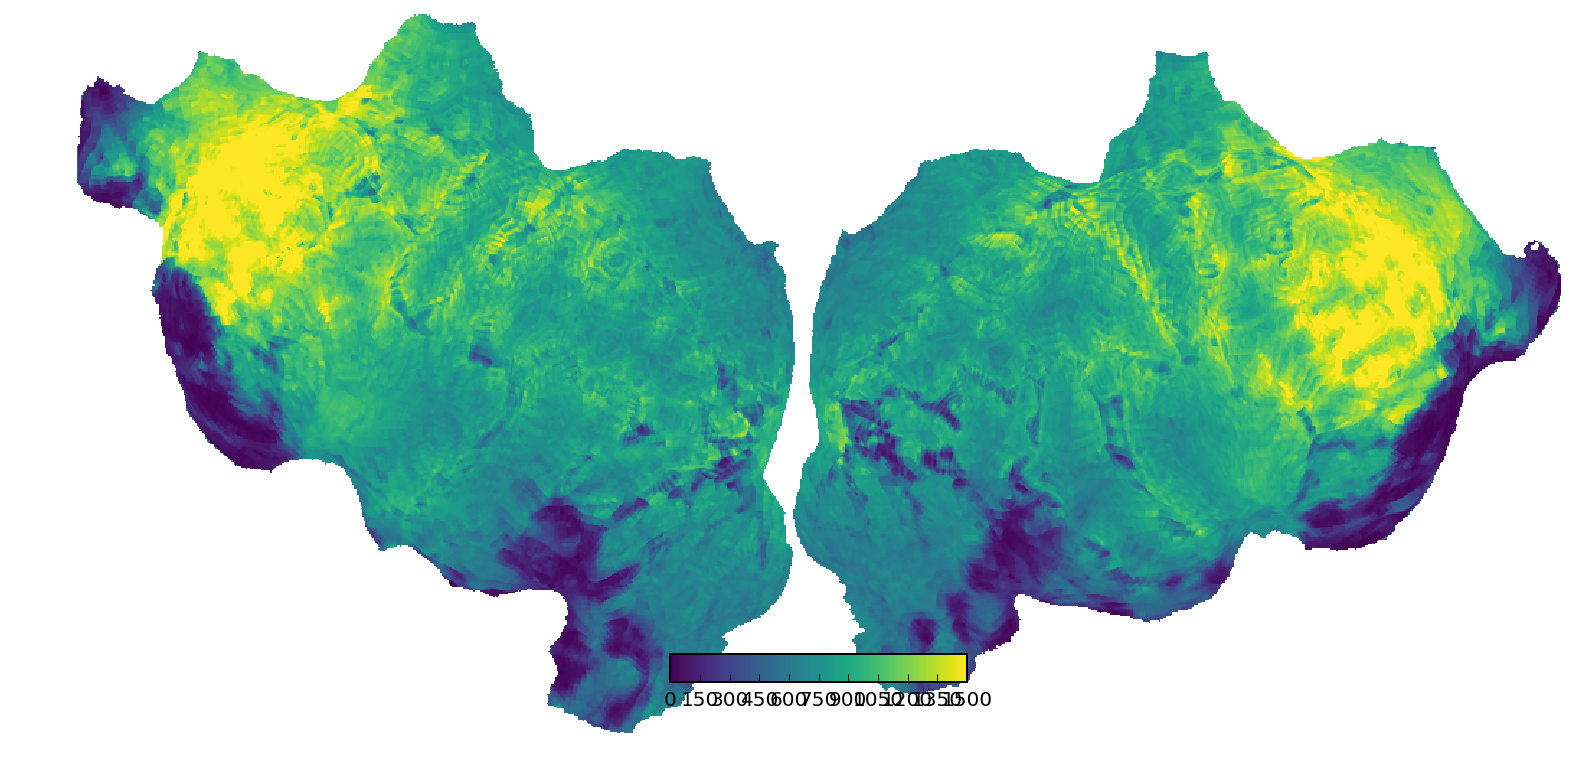

In [14]:
# Show a flatmap inline
# (If you get warnings about a module called shapely, ignore them; they are not important.)
_ = cortex.quickflat.make_figure(data_volume)

## Masks
pycortex can be used to generate cortical masks; this is where the mask we used above came from.

In [15]:
mask = cortex.db.get_mask(subject, transform, type='cortical')
first_volume_masked = voldata[0, mask]
print('Shape of mask: ', mask.shape)
print('Shape of masked data: ', first_volume_masked.shape)

Shape of mask:  (30, 100, 100)
Shape of masked data:  (38543,)


pycortex can also directly visualize masked data

In [16]:
# Show creation of volume from masked data
print(data.shape)
kwargs = dict(vmin=-3, vmax=3)
vol = cortex.Volume(data[0], subject, transform, mask=mask, **kwargs)
print(vol)
print(vol.shape)

(120, 38543)
<Custom masked data for (S2, S2_category_auto)>
(30, 100, 100)


In [ ]:
# Display this volume, too

# Select other timepoints to display


In [17]:
### TEACHER INFO
# Volume 0
#cortex.webgl.show(vol)
# Volume n
vol = cortex.webgl.show(cortex.Volume(data[30], subject, transform, mask=mask, **kwargs))
# Note artifacts near beginning / end of scan (visible as high responses in movies for first / last few volumes). 
# This has to do with detrending / magnet start-up... Many analyses will simply clip start / end, but for this 
# data they have not been clipped. Ask what this might do to conclusions drawn from data.

Testing new webshow...
https://data8.berkeley.edu/user/mark.lescroart/proxy/51030/mixer.html
Started server on port 51030


['rois']


In [ ]:
# Create a movie volume
data_movie = cortex.Volume(data, subject, transform, mask=mask, vmin=-3, vmax=3)

In [ ]:
# 3D web display takes a 4D volume, too
cortex.webgl.show(data_movie)

### Breakout session
> Find interesting time points in the experiment! Do different parts of the brain appear to be active at different times? Which parts? Try to create a mask that selects voxels in an interesting part of the brain based on the responses at particular points in the timecourse.

---